In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.Container {width:85% !important;}
div.CodeMirror {font-family:NanumGothic; font-size:13pt; line-height : 150%;}
div.output_area pre {font-family:NanumGothic; font-size:13pt; line-height : 150%;}
div.output_wrapper pre {font-family:NanumGothic; font-size:13pt; line-height : 150%;}
div.input {font-family:NanumGothic; font-size:13pt; line-height : 150%;}
</style>
"""))

In [5]:
import warnings
warnings.filterwarnings(action = 'ignore')

In [6]:
import numpy as np # 1. 데이터 셋
import pandas as pd

from sklearn.preprocessing import MinMaxScaler # 2. 데이터 전처리
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential # 3. 모델 생성
from tensorflow.keras.layers import Dense, Dropout

from matplotlib import pyplot as plt # 4. 모델 학습 & 평가

In [7]:
# ★ 1. 데이터 셋 생성 or 불러오기
raw_data = pd.read_excel('./data/heart-disease.xlsx')
# http://archive.ics.uci.edu/ml/datasets/heart+disease

raw_data.head()

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,0,108,1,1.5,2,3,3,1
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          303 non-null    object 
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            303 non-null    object 
 12  hsl           303 non-null    object 
 13  heartDisease  303 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 33.3+ KB


In [11]:
# ★ 2. 데이터 전처리(결측치 제거)
raw_data[(raw_data['chol'] == '?') | (raw_data['ca'] == '?') | (raw_data['hsl'] == '?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [12]:
clean_data = raw_data.replace('?', np.nan)

clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          302 non-null    float64
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            299 non-null    float64
 12  hsl           301 non-null    float64
 13  heartDisease  303 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 33.3 KB


In [13]:
clean_data.dropna(how = 'any', inplace = True, axis = 0)

clean_data.isna().sum()

age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [17]:
clean_data.shape # 13열까지 예측변수

# 독립(예측, 입력)변수 : heartDisease열을 제외한 전체
Input = clean_data.iloc[:, :-1]

# heartDisease열은 타겟(결과, 종속)변수
Target = clean_data.iloc[:, [-1]]

Target

,heartDisease
0,0
1,1
3,0
4,0
5,0
...,...
297,1
298,1
299,1
300,1


In [19]:
# 전체 296개의 데이터 중 심장병이 걸린 케이스의 수
Target['heartDisease'].sum()

136

In [21]:
Target['heartDisease'].mean()

0.4594594594594595

In [22]:
Target['heartDisease'].value_counts()

0    160
1    136
Name: heartDisease, dtype: int64

In [25]:
# Scale 조정
scaler = MinMaxScaler()
scaler.fit(Input)

scaled_input = pd.DataFrame(scaler.transform(Input))

scaled_input.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,296.000000,296.000000,296.000000,296.000000,296.000000,296.00000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000
mean,0.531250,0.675676,0.718468,0.355973,0.277197,0.14527,0.493243,0.600526,0.324324,0.169409,0.300676,0.224099,0.430743
std,0.188248,0.468915,0.321749,0.167734,0.118892,0.35297,0.497405,0.175183,0.468915,0.187842,0.309400,0.312461,0.484349
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.395833,0.000000,0.666667,0.245283,0.194064,0.00000,0.000000,0.479008,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.562500,1.000000,0.666667,0.339623,0.267123,0.00000,0.250000,0.625954,0.000000,0.129032,0.500000,0.000000,0.000000
75%,0.666667,1.000000,1.000000,0.433962,0.343037,0.00000,1.000000,0.725191,1.000000,0.258065,0.500000,0.333333,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
# scaled_input, Target → (학습셋 : 테스트셋 = 7 : 3)으로 분리 (무작위)
X_train, X_test, Y_train, Y_test = train_test_split(scaled_input, Target, 
                                                    test_size = 0.3, random_state = 5)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((207, 13), (207, 1), (89, 13), (89, 1))

In [27]:
# ★ 3. 모델 생성
model = Sequential()

# 파라미터가 많으면 과적합이 일어날 수 있다.
model.add(Dense(input_dim = 13, units = 500, activation = 'tanh'))
# 과적합을 해결하고자 두루뭉술하게 기억 (노드에 연결된 엣지가 없는 것으로 간주)
# Dropout : 노드를 학습에서 무시
model.add(Dropout(0.1)) 

model.add(Dense(units = 200, activation = 'tanh'))
model.add(Dropout(0.1))

model.add(Dense(units = 100, activation = 'tanh'))
model.add(Dropout(0.1))

model.add(Dense(units = 1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               7000      
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               100200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [28]:
# ★ 4. 학습과정 설정
# 분류분석일 때, 성능평가지표
# 1) accuracy(정확도) : *예측값과 실측값이 동일한 건수* / 전체건수
# 2) recall(재현률) : 찾아야 할 것중에 실제로 찾은 비율은?
# 3) precision(정밀도) : 예측한 것중에 정답의 비율은?
# 4) confusion matrix(오차 행렬) : 분류 모델이 예측을 수행하면서 얼마나 헷갈리고(confused) 있는가?
# 5) f1 score : 정밀도와 재현율의 평균
# 6) roc / auc : FPR이 변할 때, 어떻게 변하는지 나타내는 곡선 / 이 곡선의 면적
from tensorflow.keras import metrics
model.compile(loss = 'binary_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy',
                         metrics.Recall(), 
                         metrics.Precision()])

In [29]:
# ★ 5. 모델 학습
hist = model.fit(X_train, Y_train, epochs = 50, 
                 batch_size = 50, verbose = 2, 
                 validation_split = 0.2) # train data중 무작위 20%를 떼서 validation data에 넣어둠

Epoch 1/50
4/4 - 1s - loss: 0.6896 - accuracy: 0.5394 - recall: 0.2794 - precision: 0.4130 - val_loss: 0.5024 - val_accuracy: 0.8095 - val_recall: 0.8095 - val_precision: 0.8095
Epoch 2/50
4/4 - 0s - loss: 0.5081 - accuracy: 0.7758 - recall: 0.8824 - precision: 0.6742 - val_loss: 0.4221 - val_accuracy: 0.8571 - val_recall: 0.7619 - val_precision: 0.9412
Epoch 3/50
4/4 - 0s - loss: 0.4121 - accuracy: 0.8364 - recall: 0.8088 - precision: 0.7971 - val_loss: 0.4721 - val_accuracy: 0.7619 - val_recall: 0.5238 - val_precision: 1.0000
Epoch 4/50
4/4 - 0s - loss: 0.4007 - accuracy: 0.8424 - recall: 0.7206 - precision: 0.8750 - val_loss: 0.3771 - val_accuracy: 0.8810 - val_recall: 0.7619 - val_precision: 1.0000
Epoch 5/50
4/4 - 0s - loss: 0.3973 - accuracy: 0.8485 - recall: 0.8235 - precision: 0.8116 - val_loss: 0.3322 - val_accuracy: 0.8810 - val_recall: 0.7619 - val_precision: 1.0000
Epoch 6/50
4/4 - 0s - loss: 0.3647 - accuracy: 0.8667 - recall: 0.8235 - precision: 0.8485 - val_loss: 0.3936 

Epoch 47/50
4/4 - 0s - loss: 0.3127 - accuracy: 0.8485 - recall: 0.7206 - precision: 0.8909 - val_loss: 0.3632 - val_accuracy: 0.8571 - val_recall: 0.8095 - val_precision: 0.8947
Epoch 48/50
4/4 - 0s - loss: 0.3145 - accuracy: 0.8424 - recall: 0.7941 - precision: 0.8182 - val_loss: 0.3497 - val_accuracy: 0.8571 - val_recall: 0.8095 - val_precision: 0.8947
Epoch 49/50
4/4 - 0s - loss: 0.3149 - accuracy: 0.8545 - recall: 0.8676 - precision: 0.7973 - val_loss: 0.3605 - val_accuracy: 0.8571 - val_recall: 0.8095 - val_precision: 0.8947
Epoch 50/50
4/4 - 0s - loss: 0.3075 - accuracy: 0.8606 - recall: 0.8088 - precision: 0.8462 - val_loss: 0.4165 - val_accuracy: 0.8095 - val_recall: 0.7143 - val_precision: 0.8824


In [30]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'recall', 'precision', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision'])

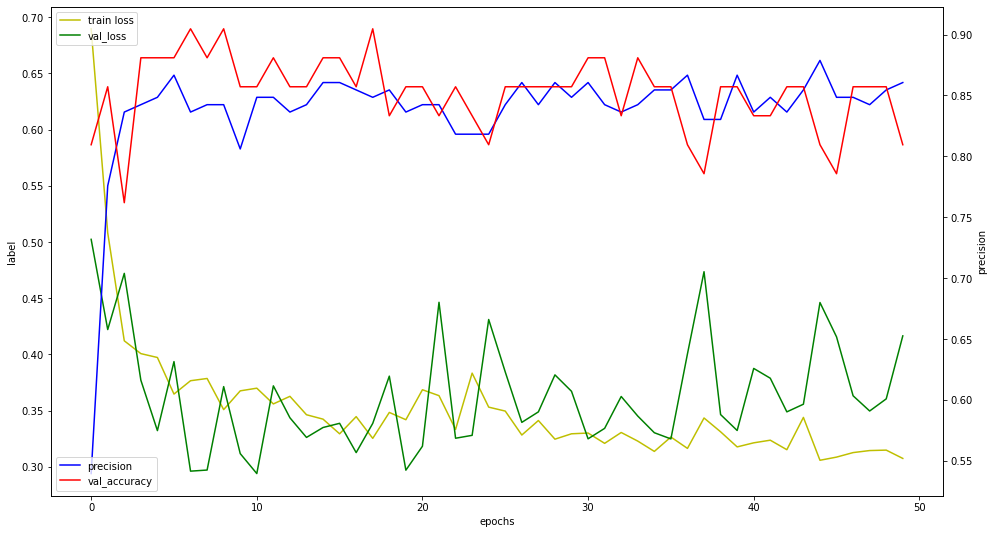

In [37]:
fig, loss_ax = plt.subplots(figsize = (16, 9))

loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist.history['val_loss'], 'g', label = 'val_loss')

loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc = 'upper left')

acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['precision'], 'b', label = 'precision')
acc_ax.plot(hist.history['val_precision'], 'r', label = 'val_precision')

acc_ax.set_ylabel('precision')
acc_ax.legend(loc = 'lower left')

plt.show()

In [41]:
# ★ 6. 모델 평가
score = model.evaluate(X_test, Y_test, verbose = 0)

print('Model loss :', score[0])
print('Model accuracy :', round(score[1]*100, 1), '%')
print('Model recall :', score[2])
print('Model precision :', round(score[3]*100, 1), '%')

Model loss : 0.49870291352272034
Model accuracy : 83.1 %
Model recall : 0.7659574747085571
Model precision : 90.0 %


In [48]:
# ★ 오차 행렬(Confusion Matrix) - 성능 평가지표
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

pred = model.predict(X_test)
pred = pred > 0.5

print(confusion_matrix(pred, Y_test), end = '\n')
print('f1_score :', round(f1_score(pred, Y_test)*100, 2), '%')

[[38 11]
 [ 4 36]]
f1_score : 82.76 %
